<a href="https://colab.research.google.com/github/zyteoh/FYP/blob/main/VGG16MaizeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive to access your dataset
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define the root directory where your dataset is located on Google Drive
dataset_root = '/content/gdrive/MyDrive/VGGdata'

In [ ]:
!ls /content/gdrive/MyDrive/VGGdata

test  train


In [ ]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2,  # Randomly zoom in/out by up to 20%
)

test_data_generator = ImageDataGenerator(rescale=1.0 / 255.0)

# Define batch size
batch_size = 64

# Create data generators for training and testing
train_generator = train_data_generator.flow_from_directory(
    os.path.join(dataset_root, 'train'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_data_generator.flow_from_directory(
    os.path.join(dataset_root, 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3199 images belonging to 4 classes.
Found 1045 images belonging to 4 classes.


In [ ]:
# Create a base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Add custom layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
num_classes = 4
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Define early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction on plateau, which reduces the learning rate if the validation loss plateaus for 3 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
# Train the model with early stopping and learning rate scheduling
history = model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
50/50 [==============================] - 2131s 42s/step - loss: 1.3036 - accuracy: 0.4439 - val_loss: 0.9869 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 65s 1s/step - loss: 0.8635 - accuracy: 0.5746 - val_loss: 0.9690 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 65s 1s/step - loss: 1.2192 - accuracy: 0.4670 - val_loss: 1.3065 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 66s 1s/step - loss: 1.4295 - accuracy: 0.3332 - val_loss: 1.3520 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 64s 1s/step - loss: 1.2984 - accuracy: 0.4364 - val_loss: 1.2189 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 65s 1s/step - loss: 1.0021 - accuracy: 0.5386 - val_loss: 0.8659 - val_accuracy: 0.5646 - lr: 1.0000e-04
Epoch 7/30
50/50 [==============================] - 65s 1s/step - loss: 0.7

In [ ]:
# Save the trained model
model.save('vgg16_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0, 0.5, 'Loss')

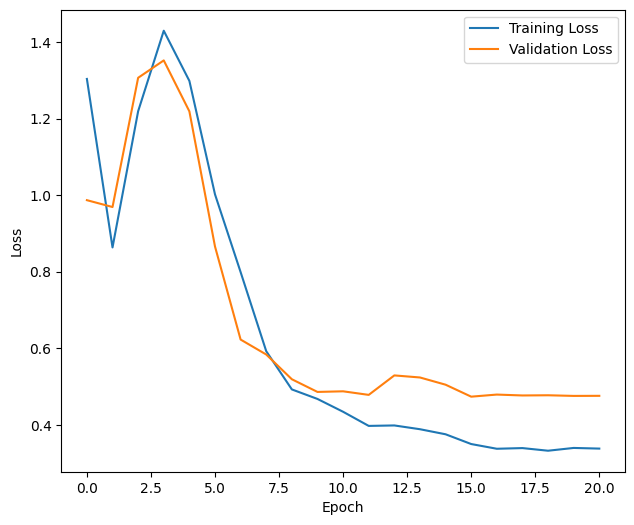

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(16, 6))  # Increase the width and height of the figure
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

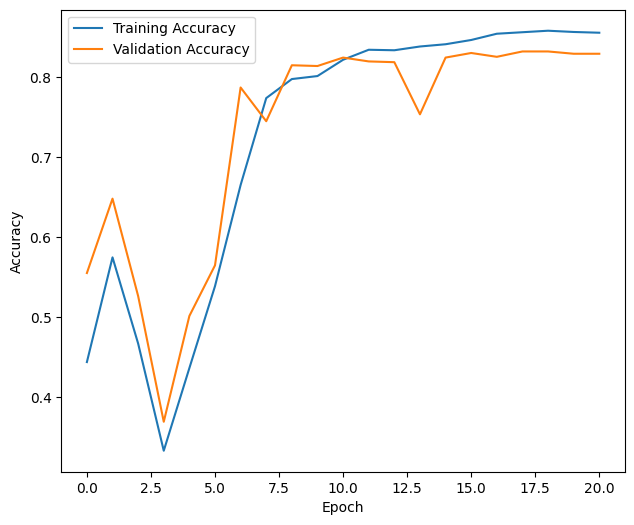

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(16, 6))  # Increase the width and height of the figure
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ...

# Evaluate the model on the test set
test_predictions = model.predict(test_generator)
test_labels = test_generator.classes

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, test_predictions.argmax(axis=1))
print(f'Overall Accuracy: {overall_accuracy}')

# Calculate F1 score for each class
f1_scores = f1_score(test_labels, test_predictions.argmax(axis=1), average=None)
print(f'F1 Scores for Each Class: {f1_scores}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions.argmax(axis=1))
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report
class_report = classification_report(test_labels, test_predictions.argmax(axis=1))
print('Classification Report:')
print(class_report)


17/17 [==============================] - 18s 994ms/step
Overall Accuracy: 0.2736842105263158
F1 Scores for Each Class: [0.30647709 0.2962963  0.0876494  0.29401709]
Confusion Matrix:
[[ 97  87  30  72]
 [110  92  35  89]
 [ 43  41  11  48]
 [ 97  75  32  86]]
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.34      0.31       286
           1       0.31      0.28      0.30       326
           2       0.10      0.08      0.09       143
           3       0.29      0.30      0.29       290

    accuracy                           0.27      1045
   macro avg       0.25      0.25      0.25      1045
weighted avg       0.27      0.27      0.27      1045



In [ ]:
#_______

In [ ]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=0,  # Randomly rotate images by up to 0 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2,  # Randomly zoom in/out by up to 20%
)

test_data_generator = ImageDataGenerator(rescale=1.0 / 255.0)

# Define batch size
batch_size = 128

# Create data generators for training and testing
train_generator = train_data_generator.flow_from_directory(
    os.path.join(dataset_root, 'train'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_data_generator.flow_from_directory(
    os.path.join(dataset_root, 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3199 images belonging to 4 classes.
Found 1045 images belonging to 4 classes.


In [ ]:
# Create a base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Add custom layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
num_classes = 4
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Define early stopping to monitor the validation loss and stop training if it doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction on plateau, which reduces the learning rate if the validation loss plateaus for 3 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
# Train the model with early stopping and learning rate scheduling
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
25/25 [==============================] - 1677s 67s/step - loss: 1.6065 - accuracy: 0.3592 - val_loss: 1.2333 - val_accuracy: 0.4794 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - 69s 3s/step - loss: 0.8765 - accuracy: 0.5724 - val_loss: 0.6534 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - 69s 3s/step - loss: 0.5275 - accuracy: 0.7687 - val_loss: 0.9694 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - 71s 3s/step - loss: 0.4564 - accuracy: 0.7956 - val_loss: 0.4988 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - 69s 3s/step - loss: 0.4027 - accuracy: 0.8153 - val_loss: 0.4439 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/20
25/25 [==============================] - 68s 3s/step - loss: 0.3884 - accuracy: 0.8203 - val_loss: 0.4567 - val_accuracy: 0.8153 - lr: 0.0010
Epoch 7/20
25/25 [==============================] - 69s 3s/step - loss: 0.3663 

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

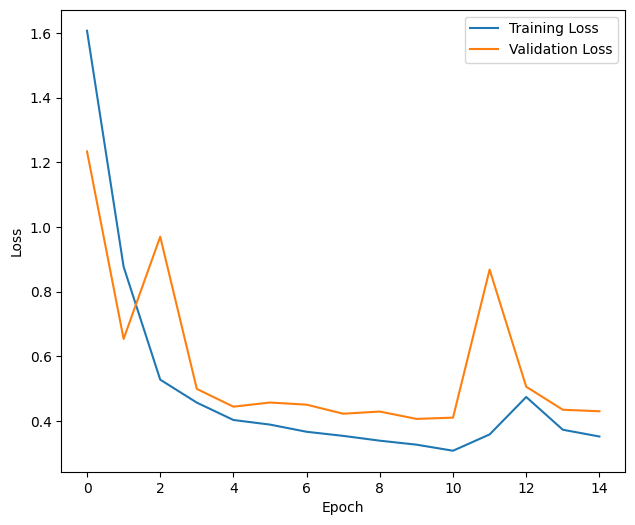

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(16, 6))  # Increase the width and height of the figure
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

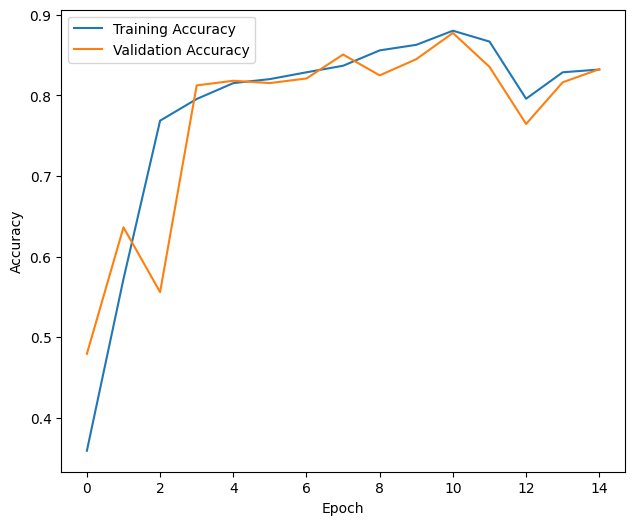

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(16, 6))  # Increase the width and height of the figure
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ...

# Evaluate the model on the test set
test_predictions = model.predict(test_generator)
test_labels = test_generator.classes

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, test_predictions.argmax(axis=1))
print(f'Overall Accuracy: {overall_accuracy}')

# Calculate F1 score for each class
f1_scores = f1_score(test_labels, test_predictions.argmax(axis=1), average=None)
print(f'F1 Scores for Each Class: {f1_scores}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions.argmax(axis=1))
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report
class_report = classification_report(test_labels, test_predictions.argmax(axis=1))
print('Classification Report:')
print(class_report)


9/9 [==============================] - 6s 660ms/step
Overall Accuracy: 0.2669856459330144
F1 Scores for Each Class: [0.28653295 0.27922078 0.07526882 0.29152542]
Confusion Matrix:
[[100  86  16  84]
 [137  86  10  93]
 [ 62  37   7  37]
 [113  81  10  86]]
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.35      0.29       286
           1       0.30      0.26      0.28       326
           2       0.16      0.05      0.08       143
           3       0.29      0.30      0.29       290

    accuracy                           0.27      1045
   macro avg       0.25      0.24      0.23      1045
weighted avg       0.26      0.27      0.26      1045



In [ ]:
import numpy as np

# Get class probability scores for the test data using model.predict
class_probs = model.predict(test_generator)

# Define custom thresholds for each class
thresholds = [0.6, 0.5, 0.4, 0.7]  # Adjust these thresholds as needed

# Initialize an empty array for predictions
custom_predictions = np.zeros_like(class_probs)

# Apply custom thresholds
for class_idx, threshold in enumerate(thresholds):
    custom_predictions[:, class_idx] = (class_probs[:, class_idx] >= threshold).astype(int)

# Assuming you have binary labels for each class (0 or 1)
binary_true_labels = np.array([test_generator.classes == i for i in range(num_classes)]).T

# Calculate F1 score for each class using binary labels
f1_scores = f1_score(binary_true_labels, custom_predictions, average=None)

# Generate a classification report
class_report = classification_report(binary_true_labels, custom_predictions, target_names=[f'Class {i}' for i in range(num_classes)])
print('Classification Report with Custom Thresholds:')
print(class_report)


9/9 [==============================] - 7s 806ms/step
Classification Report with Custom Thresholds:
              precision    recall  f1-score   support

     Class 0       0.28      0.36      0.32       286
     Class 1       0.29      0.26      0.27       326
     Class 2       0.13      0.07      0.09       143
     Class 3       0.25      0.26      0.25       290

   micro avg       0.26      0.26      0.26      1045
   macro avg       0.24      0.24      0.23      1045
weighted avg       0.26      0.26      0.25      1045
 samples avg       0.26      0.26      0.26      1045



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Extract the validation accuracy from the 'history' object
val_accuracy = history.history['val_accuracy']

# Print the validation accuracy
print(f'Validation Accuracy: {val_accuracy[-1]}')

Validation Accuracy: 0.8325358629226685
